# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Recommender Model Implementation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
%pip install scikit-learn numpy pandas optuna tqdm plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import optuna
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the cleaned dataset

In [3]:
# Define the same column names from the EDA notebook
feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
                'balance', 'uniformity', 'clean_cup', 'sweetness']
label_cols = ['country_of_origin', 'variety', 'processing_method']

### Cleaned dataset

In [4]:
# Read the cleaned dataset
loaded_df = pd.read_csv('datasets/preprocessed_coffee_data.csv')

# Split into X and y using these column names
X = loaded_df[feature_cols].to_numpy()
y = loaded_df[label_cols].to_numpy()

### Cleaned dataset with oversampling (SMOTE)

In [5]:
smote_df = pd.read_csv('datasets/preprocessed_coffee_data_resampled.csv')

# Split into X and y using these column names
X_smote = smote_df[feature_cols].to_numpy()
y_smote = smote_df[label_cols].to_numpy()

## Split the dataset into training and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [7]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=0
)

## Recommender Models
- Truncated SVD
- Non-negative Matrix Factorization

### Helper function for inference

In [8]:
# Get predictions
def get_top_k_predictions(train_transformed, test_transformed, y_train, k=5):
    similarities = cosine_similarity(test_transformed, train_transformed)
    predictions = []
    for i in range(len(test_transformed)):
        similar_indices = similarities[i].argsort()[::-1][:k]
        pred_countries = y_train[similar_indices, 0]
        pred_varieties = y_train[similar_indices, 1]
        pred_processes = y_train[similar_indices, 2]
        predictions.append((pred_countries, pred_varieties, pred_processes))
    return predictions

## Evaluation metrics
- Mean Average Precision (mAP)
- Precision@K
- Recall@K

In [9]:
def compute_map(y_true, predictions, weights, k=5):
    """
    Compute Mean Average Precision (mAP) for multi-label recommendation tasks.
    
    Parameters:
    -----------
    y_true : array-like
        True labels for the test data (country, variety, process).
    predictions : list of tuples
        Predicted top-k values for each label (countries, varieties, processes).
    weights : dict
        Weights for each label type.
    k : int, default=5
        Number of top predictions to consider.
    
    Returns:
    --------
    float
        Mean Average Precision (mAP) score.
    """
    ap_scores = []

    for i in range(len(y_true)):
        true_country, true_variety, true_process = y_true[i]
        pred_countries, pred_varieties, pred_processes = predictions[i]

        correct_country = 0
        correct_variety = 0
        correct_process = 0
        relevant_precisions = []

        for j in range(k):
            relevant_at_position = False
            
            # Check if current position contains any relevant items
            if pred_countries[j] == true_country:
                correct_country += 1
                relevant_at_position = True
            if pred_varieties[j] == true_variety:
                correct_variety += 1
                relevant_at_position = True
            if pred_processes[j] == true_process:
                correct_process += 1
                relevant_at_position = True

            # Only include precision if we found a relevant item
            if relevant_at_position:
                precision = (
                    weights['country'] * correct_country / (j + 1) +
                    weights['variety'] * correct_variety / (j + 1) +
                    weights['process'] * correct_process / (j + 1)
                )
                relevant_precisions.append(precision)

        # Calculate AP using only positions with relevant items
        ap = sum(relevant_precisions) / k  # Normalize by k to penalize missing relevant items
        ap_scores.append(ap)

    return np.mean(ap_scores)


def compute_precision_at_k(y_true, predictions, weights, k=5):
    """
    Calculate both weighted and individual Precision@k for multi-label predictions.
    
    This function computes precision at k in two ways:
    1. Individual precision for each label type (country, variety, process)
    2. Weighted combination of precisions using provided weights
    
    Parameters:
    -----------
    y_true : array-like
        True labels for the test data (country, variety, process).
    predictions : list of tuples
        Predicted top-k values for each label (countries, varieties, processes).
    weights : dict
        Weights for each label type.
    k : int, default=5
        Number of top predictions to consider.
    
    Returns:
    --------
    dict
        Dictionary containing both weighted and individual precision scores:
        - 'weighted': Overall weighted precision@k
        - 'country': Precision@k for country predictions
        - 'variety': Precision@k for variety predictions
        - 'process': Precision@k for process predictions
    """
    # Initialize counters for each label type
    total_precision = 0
    total_precision_country = 0
    total_precision_variety = 0
    total_precision_process = 0
    
    for i in range(len(y_true)):
        # Extract true labels and predictions
        true_country, true_variety, true_process = y_true[i]
        pred_countries, pred_varieties, pred_processes = predictions[i]

        # Calculate correct predictions for each label type
        correct_countries = sum(1 for c in pred_countries[:k] if c == true_country)
        correct_varieties = sum(1 for v in pred_varieties[:k] if v == true_variety)
        correct_processes = sum(1 for p in pred_processes[:k] if p == true_process)

        # Calculate individual precisions
        precision_country = correct_countries / k
        precision_variety = correct_varieties / k
        precision_process = correct_processes / k

        # Add to total individual precisions
        total_precision_country += precision_country
        total_precision_variety += precision_variety
        total_precision_process += precision_process

        # Calculate weighted precision for this instance
        weighted_precision = (
            weights['country'] * precision_country +
            weights['variety'] * precision_variety +
            weights['process'] * precision_process
        )
        total_precision += weighted_precision

    # Calculate final averages
    n_samples = len(y_true)
    return {
        'weighted': total_precision / n_samples,
        'country': total_precision_country / n_samples,
        'variety': total_precision_variety / n_samples,
        'process': total_precision_process / n_samples
    }
    
    
def compute_recall_at_k(y_true, predictions, weights, k=5):
    """
    Calculate recall@k for multi-label predictions.
    
    Recall@k = (Number of relevant items in top-k recommendations) / (Total number of relevant items)
    
    Parameters:
    -----------
    y_true : array-like
        True labels for the test data (country, variety, process).
    predictions : list of tuples
        Predicted top-k values for each label (countries, varieties, processes).
    k : int, default=5
        Number of top predictions to consider.
    
    Returns:
    --------
    dict
        Dictionary containing recall scores for each label type:
        - 'country': Recall@k for country predictions
        - 'variety': Recall@k for variety predictions
        - 'process': Recall@k for process predictions
    """
    # First, count total occurrences of each label in the test set
    total_countries = {}
    total_varieties = {}
    total_processes = {}
    
    # Count the total occurrences of each label in the test set
    for true_country, true_variety, true_process in y_true:
        total_countries[true_country] = total_countries.get(true_country, 0) + 1
        total_varieties[true_variety] = total_varieties.get(true_variety, 0) + 1
        total_processes[true_process] = total_processes.get(true_process, 0) + 1
    
    # Initialize counters for correct predictions
    correct_countries = {}
    correct_varieties = {}
    correct_processes = {}
    
    # Count correct predictions in top-k for each label
    for i, (true_country, true_variety, true_process) in enumerate(y_true):
        pred_countries, pred_varieties, pred_processes = predictions[i]
        
        # Count correct predictions for each true label
        if true_country in pred_countries[:k]:
            correct_countries[true_country] = correct_countries.get(true_country, 0) + 1
            
        if true_variety in pred_varieties[:k]:
            correct_varieties[true_variety] = correct_varieties.get(true_variety, 0) + 1
            
        if true_process in pred_processes[:k]:
            correct_processes[true_process] = correct_processes.get(true_process, 0) + 1
    
    # Calculate recall for each label type
    country_recall = sum(correct_countries.get(country, 0) / total 
                        for country, total in total_countries.items()) / len(total_countries)
    
    variety_recall = sum(correct_varieties.get(variety, 0) / total 
                        for variety, total in total_varieties.items()) / len(total_varieties)
    
    process_recall = sum(correct_processes.get(process, 0) / total 
                        for process, total in total_processes.items()) / len(total_processes)
    
    # Calculate weighted recall
    weighted_recall = (
        weights['country'] * country_recall +
        weights['variety'] * variety_recall +
        weights['process'] * process_recall
    )
    
    return {
        'weighted': weighted_recall,
        'country': country_recall,
        'variety': variety_recall,
        'process': process_recall
    }


def evaluate_recommendations(y_test, predictions, k=5):
    """
    Evaluate recommender system using precomputed predictions and various metrics.
    
    This function provides a comprehensive evaluation of the recommender system,
    including both overall performance metrics and detailed breakdowns by label type.
    
    Parameters:
    -----------
    y_test : array-like
        True labels for the test data (country, variety, process).
    predictions : list of tuples
        Predicted top-k values for each label (countries, varieties, processes).
    k : int, default=5
        Number of top predictions to consider.
    
    Returns:
    --------
    dict
        Comprehensive evaluation metrics including:
        - Overall weighted precision@k
        - Individual precision@k for each label type
        - Mean Average Precision (mAP)
    """
    # Define weights
    weights = {'country': 1/3, 'variety': 1/3, 'process': 1/3}
    # print(f"Label Weights for Evaluation: {weights}")
    
    # Compute all precision metrics
    precision_metrics = compute_precision_at_k(y_test, predictions, weights, k)
    recall_metrics = compute_recall_at_k(y_test, predictions, weights, k)
    map_score = compute_map(y_test, predictions, weights, k)
    
    # Create final results dictionary
    results = {
        f"precision@{k}_weighted": precision_metrics['weighted'],
        f"precision@{k}_country": precision_metrics['country'],
        f"precision@{k}_variety": precision_metrics['variety'],
        f"precision@{k}_process": precision_metrics['process'],
        f"recall@{k}_weighted": recall_metrics['weighted'],
        f"recall@{k}_country": recall_metrics['country'],
        f"recall@{k}_variety": recall_metrics['variety'],
        f"recall@{k}_process": recall_metrics['process'],
        "map": map_score
    }
    
    # Print detailed results
    print("\nDetailed Evaluation Results:")
    print(f"{'Metric':<25} {'Score':<10}")
    print("-" * 35)
    for metric, score in results.items():
        print(f"{metric:<25} {score:.4f}")
    
    return results

### SVD Implementation

In [10]:
# Scale the data
scaler = StandardScaler()
X_train_std_scaled = scaler.fit_transform(X_train)
X_test_std_scaled = scaler.transform(X_test)

# Train SVD
svd = TruncatedSVD(n_components=2, random_state=0)
X_train_svd = svd.fit_transform(X_train_std_scaled)

# Transform test data
X_test_svd = svd.transform(X_test_std_scaled)

# Inference
svd_predictions = get_top_k_predictions(X_train_svd, X_test_svd, y_train, k=5)

# Evaluate metrics using precomputed predictions
svd_metrics = evaluate_recommendations(y_test, svd_predictions, k=5)


Detailed Evaluation Results:
Metric                    Score     
-----------------------------------
precision@5_weighted      0.2657
precision@5_country       0.1604
precision@5_variety       0.1836
precision@5_process       0.4530
recall@5_weighted         0.3394
recall@5_country          0.3630
recall@5_variety          0.1666
recall@5_process          0.4885
map                       0.2085


### NMF Implementation

In [11]:
# Train NMF
nmf = NMF(n_components=2, init='nndsvd', random_state=0)
X_train_nmf = nmf.fit_transform(X_train)

# Transform test data
X_test_nmf = nmf.transform(X_test)

# Inference
nmf_predictions = get_top_k_predictions(X_train_nmf, X_test_nmf, y_train, k=5)

# Evaluate metrics using precomputed predictions
nmf_metrics = evaluate_recommendations(y_test, nmf_predictions, k=5)


Detailed Evaluation Results:
Metric                    Score     
-----------------------------------
precision@5_weighted      0.2535
precision@5_country       0.1403
precision@5_variety       0.1791
precision@5_process       0.4410
recall@5_weighted         0.3452
recall@5_country          0.4123
recall@5_variety          0.1808
recall@5_process          0.4425
map                       0.2098


/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## Evaluate the recommender models

In [12]:
def plot_metrics_comparison(svd_metrics, nmf_metrics):
    """
    Plot comparison of model metrics
    
    Parameters:
    -----------
    svd_metrics : dict
        Dictionary of SVD model metrics
    nmf_metrics : dict
        Dictionary of NMF model metrics
    """
    metrics = list(svd_metrics.keys())
    svd_values = list(svd_metrics.values())
    nmf_values = list(nmf_metrics.values())
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, svd_values, width, label='SVD', color='skyblue')
    rects2 = ax.bar(x + width/2, nmf_values, width, label='NMF', color='lightcoral')
    
    # Add value labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', rotation=0)
    
    autolabel(rects1)
    autolabel(rects2)
    
    ax.set_ylabel('Score')
    ax.set_title('Comparison of SVD and NMF Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    

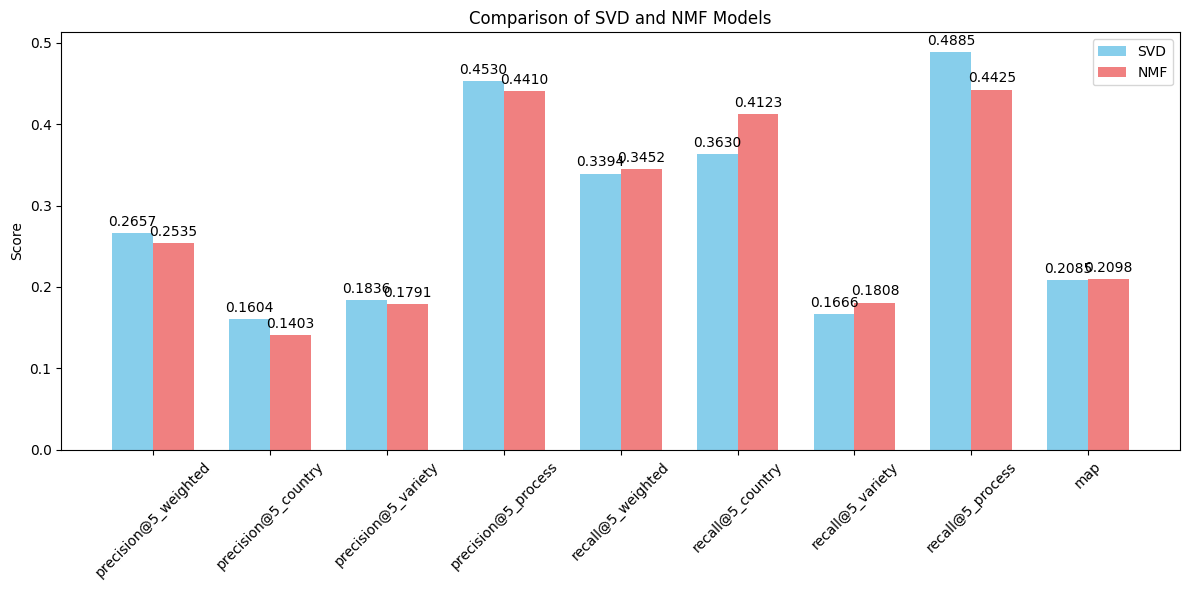

In [13]:
plot_metrics_comparison(svd_metrics, nmf_metrics)

## Perform hyperparameter optimization

### Objective Functions

In [14]:
def objective_svd(trial, X_train_scaled, y_train, weights={'country': 0.4, 'variety': 0.4, 'process': 0.2}):
    """
    Objective function for SVD hyperparameter optimization with multi-label precision
    """
    min_dim = min(X_train_scaled.shape)
    algorithm = trial.suggest_categorical('algorithm', ['randomized', 'arpack'])
    
    n_components = trial.suggest_int('n_components', 2, 
                                   min(min_dim - 1, 15) if algorithm == 'arpack' else min(min_dim, 15))
    
    try:
        svd = TruncatedSVD(
            n_components=n_components,
            algorithm=algorithm,
            tol=1e-4,
            random_state=0,
            n_iter=10000
        )
        
        X_transformed = svd.fit_transform(X_train_scaled)
        k = 10
        cv_scores = []
        
        kf = KFold(n_splits=5, shuffle=True, random_state=0)
        
        for train_idx, val_idx in kf.split(X_transformed):
            X_train_fold, X_val_fold = X_transformed[train_idx], X_transformed[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Get predictions using your top-k function
            predictions = get_top_k_predictions(X_train_fold, X_val_fold, y_train_fold, k)
            
            # Calculate precision using your multi-label function
            metrics = compute_precision_at_k(y_val_fold, predictions, weights, k)
            
            # Use the weighted precision score
            cv_scores.append(metrics['weighted'])
        
        return np.mean(cv_scores)
    
    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        return float('-inf')

In [15]:
def objective_nmf(trial, X_train, y_train, weights={'country': 0.4, 'variety': 0.4, 'process': 0.2}):
    """
    Objective function for NMF hyperparameter optimization with multi-label precision
    """
    min_dim = min(X_train.shape)
    solver = trial.suggest_categorical('solver', ['cd', 'mu'])
    beta_loss = 'frobenius' if solver == 'cd' else trial.suggest_categorical('beta_loss', 
                                                                           ['frobenius', 'kullback-leibler'])
    
    n_components = trial.suggest_int('n_components', 2, min(min_dim, 15))
    init = trial.suggest_categorical('init', ['nndsvd', 'nndsvdar', 'random', None])
    
    try:
        nmf = NMF(
            n_components=n_components,
            init=init,
            solver=solver,
            beta_loss=beta_loss,
            max_iter=10000,
            random_state=0
        )
        
        X_transformed = nmf.fit_transform(X_train)
        k = 5
        cv_scores = []
        
        kf = KFold(n_splits=5, shuffle=True, random_state=0)
        
        for train_idx, val_idx in kf.split(X_transformed):
            X_train_fold, X_val_fold = X_transformed[train_idx], X_transformed[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            predictions = get_top_k_predictions(X_train_fold, X_val_fold, y_train_fold, k)
            metrics = compute_precision_at_k(y_val_fold, predictions, weights, k)
            cv_scores.append(metrics['weighted'])
        
        return np.mean(cv_scores)
    
    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        return float('-inf')

### Optimization Functions

In [16]:
def optimize_svd(X_train_scaled, y_train, n_trials=50):
    """
    Optimize both SVD model using Optuna
    """
    # Create studies for both models
    svd_study = optuna.create_study(direction='maximize')
    
    # Optimize SVD
    print("Optimizing SVD...")
    svd_study.optimize(
        lambda trial: objective_svd(trial, X_train_scaled, y_train),
        n_trials=n_trials
    )
    
    # Get best parameters
    best_svd_params = svd_study.best_params
    
    # Create optimized SVD model
    svd_params = {
        'n_components': best_svd_params['n_components'],
        'algorithm': best_svd_params['algorithm'],
        'tol': 1e-4,
        "n_iter": 10000,
        'random_state': 0
    }
    if best_svd_params['algorithm'] == 'randomized':
        svd_params['n_iter'] = 1000
    best_svd = TruncatedSVD(**svd_params)
    
    return best_svd, svd_study

def optimize_nmf(X_train_scaled, y_train, n_trials=50):
    """
    Optimize NMF model using Optuna
    """
    # Create study
    nmf_study = optuna.create_study(direction='maximize')
    
    # Optimize NMF
    print("\nOptimizing NMF...")
    nmf_study.optimize(
        lambda trial: objective_nmf(trial, X_train_scaled, y_train),
        n_trials=n_trials
    )
    
    # Get best parameters
    best_nmf_params = nmf_study.best_params
        
    # Create optimized NMF model
    best_nmf = NMF(
        **best_nmf_params,
        max_iter=10000,
        random_state=0
    )
    
    return best_nmf, nmf_study

[I 2024-12-11 02:07:52,201] A new study created in memory with name: no-name-d89a55c3-017c-465c-9771-7f5e1d713c1a


Optimizing SVD...


[I 2024-12-11 02:07:52,250] Trial 0 finished with value: 0.24411460664297308 and parameters: {'algorithm': 'arpack', 'n_components': 6}. Best is trial 0 with value: 0.24411460664297308.
[I 2024-12-11 02:07:52,297] Trial 1 finished with value: 0.24411460664297308 and parameters: {'algorithm': 'arpack', 'n_components': 6}. Best is trial 0 with value: 0.24411460664297308.
[I 2024-12-11 02:07:53,049] Trial 2 finished with value: 0.24411460664297308 and parameters: {'algorithm': 'randomized', 'n_components': 6}. Best is trial 0 with value: 0.24411460664297308.
[I 2024-12-11 02:07:53,783] Trial 3 finished with value: 0.24411460664297308 and parameters: {'algorithm': 'randomized', 'n_components': 6}. Best is trial 0 with value: 0.24411460664297308.
[I 2024-12-11 02:07:53,828] Trial 4 finished with value: 0.23537852661138156 and parameters: {'algorithm': 'arpack', 'n_components': 4}. Best is trial 0 with value: 0.24411460664297308.
[I 2024-12-11 02:07:54,564] Trial 5 finished with value: 0.257

SVD optimization time: 30.37 seconds
SVD training time: 0.07 seconds
SVD inference time: 0.01 seconds

Optimizing NMF...


[I 2024-12-11 02:08:22,780] Trial 1 finished with value: 0.23216357334035345 and parameters: {'solver': 'mu', 'beta_loss': 'kullback-leibler', 'n_components': 3, 'init': None}. Best is trial 1 with value: 0.23216357334035345.
[I 2024-12-11 02:08:22,921] Trial 2 finished with value: 0.2247244965117808 and parameters: {'solver': 'cd', 'n_components': 2, 'init': 'random'}. Best is trial 1 with value: 0.23216357334035345.
[I 2024-12-11 02:08:22,968] Trial 3 finished with value: 0.23860681848097917 and parameters: {'solver': 'cd', 'n_components': 4, 'init': None}. Best is trial 3 with value: 0.23860681848097917.
[I 2024-12-11 02:08:23,017] Trial 4 finished with value: 0.22966258610855136 and parameters: {'solver': 'cd', 'n_components': 3, 'init': None}. Best is trial 3 with value: 0.23860681848097917.
/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver


NMF optimization time: 20.44 seconds
NMF training time: 0.66 seconds
NMF inference time: 0.02 seconds

Detailed Evaluation Results:
Metric                    Score     
-----------------------------------
precision@5_weighted      0.3107
precision@5_country       0.2239
precision@5_variety       0.2209
precision@5_process       0.4873
recall@5_weighted         0.4448
recall@5_country          0.5062
recall@5_variety          0.2251
recall@5_process          0.6029
map                       0.2687

Detailed Evaluation Results:
Metric                    Score     
-----------------------------------
precision@5_weighted      0.2639
precision@5_country       0.1739
precision@5_variety       0.1866
precision@5_process       0.4313
recall@5_weighted         0.3936
recall@5_country          0.4567
recall@5_variety          0.1446
recall@5_process          0.5796
map                       0.2184


/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


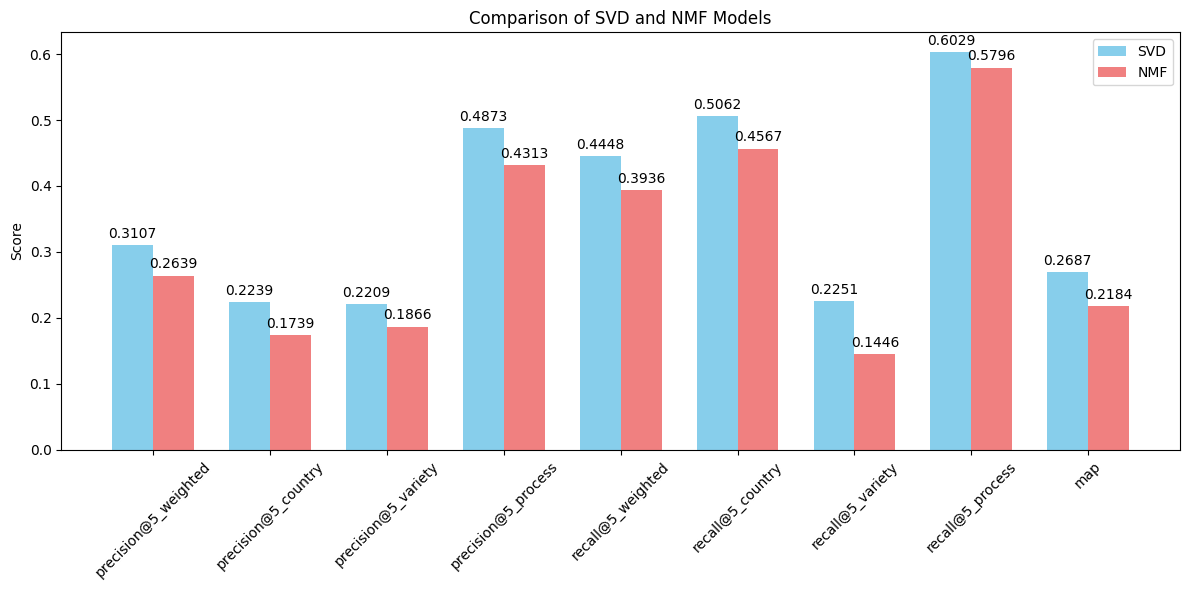


Timing Comparison Summary:
--------------------------------------------------
Model      Training (s)    Inference (s)   Total (s)      
--------------------------------------------------
SVD        0.07            0.01            30.45          
NMF        0.66            0.02            21.11          


In [17]:
import time

# Dictionary to store timing results
timing_results = {
    'svd': {'training': 0, 'inference': 0, 'total': 0},
    'nmf': {'training': 0, 'inference': 0, 'total': 0}
}

# Start timing SVD pipeline
svd_start_time = time.time()

# Time SVD optimization
optimization_start = time.time()
best_svd, svd_study = optimize_svd(X_train, y_train, n_trials=50)
optimization_time = time.time() - optimization_start
print(f"SVD optimization time: {optimization_time:.2f} seconds")

# Time SVD training
train_start = time.time()
X_train_svd = best_svd.fit_transform(X_train_std_scaled)
train_time = time.time() - train_start
timing_results['svd']['training'] = train_time
print(f"SVD training time: {train_time:.2f} seconds")

# Time SVD inference
inference_start = time.time()
X_test_svd = best_svd.transform(X_test_std_scaled)
svd_predictions = get_top_k_predictions(X_train_svd, X_test_svd, y_train, k=5)
inference_time = time.time() - inference_start
timing_results['svd']['inference'] = inference_time
print(f"SVD inference time: {inference_time:.2f} seconds")

# Calculate total SVD time
timing_results['svd']['total'] = time.time() - svd_start_time

# Start timing NMF pipeline
nmf_start_time = time.time()

# Time NMF optimization
optimization_start = time.time()
best_nmf, nmf_study = optimize_nmf(X_train, y_train, n_trials=50)
optimization_time = time.time() - optimization_start
print(f"\nNMF optimization time: {optimization_time:.2f} seconds")

# Time NMF training
train_start = time.time()
X_train_nmf = best_nmf.fit_transform(X_train)
train_time = time.time() - train_start
timing_results['nmf']['training'] = train_time
print(f"NMF training time: {train_time:.2f} seconds")

# Time NMF inference
inference_start = time.time()
X_test_nmf = best_nmf.transform(X_test)
nmf_predictions = get_top_k_predictions(X_train_nmf, X_test_nmf, y_train, k=5)
inference_time = time.time() - inference_start
timing_results['nmf']['inference'] = inference_time
print(f"NMF inference time: {inference_time:.2f} seconds")

# Calculate total NMF time
timing_results['nmf']['total'] = time.time() - nmf_start_time

# Evaluate optimized models
svd_metrics = evaluate_recommendations(y_test, svd_predictions, k=5)
nmf_metrics = evaluate_recommendations(y_test, nmf_predictions, k=5)

# Plot metrics comparison
plot_metrics_comparison(svd_metrics, nmf_metrics)

# Print timing comparison summary
print("\nTiming Comparison Summary:")
print("-" * 50)
print(f"{'Model':<10} {'Training (s)':<15} {'Inference (s)':<15} {'Total (s)':<15}")
print("-" * 50)
for model in ['svd', 'nmf']:
    print(f"{model.upper():<10} {timing_results[model]['training']:<15.2f} "
          f"{timing_results[model]['inference']:<15.2f} "
          f"{timing_results[model]['total']:<15.2f}")

## Train the recommender systems on oversampled dataset

### SVD Implementation

In [18]:
# # Scale the data
# scaler = StandardScaler()
# X_train_smote_std_scaled = scaler.fit_transform(X_train_smote)
# X_test_smote_std_scaled = scaler.transform(X_test_smote)

# # Train SVD
# svd = TruncatedSVD(n_components=5, random_state=0)
# X_train_smote_svd = svd.fit_transform(X_train_smote_std_scaled)

# # Transform test data
# X_test_smote_svd = svd.transform(X_test_smote_std_scaled)

# # Inference
# svd_smote_predictions = get_top_k_predictions(X_train_smote_svd, X_test_smote_svd, y_train_smote)

# # Evaluate metrics using precomputed predictions
# svd_smote_metrics = evaluate_recommendations(y_test_smote, svd_smote_predictions, k=5)

# # Print results
# print(svd_smote_metrics)

### NMF Implementation

In [19]:
# # Train NMF
# nmf = NMF(n_components=9, random_state=0)
# X_train_smote_nmf = nmf.fit_transform(X_train_smote)

# # Transform test data
# X_test_smote_nmf = nmf.transform(X_test_smote)

# # Inference
# nmf_smote_predictions = get_top_k_predictions(X_train_smote_nmf, X_test_smote_nmf, y_train_smote)

# # Evaluate metrics using precomputed predictions
# nmf_smote_metrics = evaluate_recommendations(y_test_smote, nmf_smote_predictions, k=5)

### Evaluate the recommender systems with oversampled data

In [20]:
# plot_metrics_comparison(svd_smote_metrics, nmf_smote_metrics)

### Hyperparameter optimization on retrained recommender systems

In [21]:
# import time

# # Dictionary to store timing results for SMOTE-augmented data
# timing_results_smote = {
#     'svd': {'training': 0, 'inference': 0, 'total': 0},
#     'nmf': {'training': 0, 'inference': 0, 'total': 0}
# }

# # Start timing SVD pipeline with SMOTE data
# svd_smote_start_time = time.time()

# # Time SVD optimization on SMOTE data
# optimization_start = time.time()
# best_svd_smote, svd_smote_study = optimize_svd(X_train_smote, y_train_smote, n_trials=50)
# optimization_time = time.time() - optimization_start
# print(f"SVD optimization time (SMOTE): {optimization_time:.2f} seconds")

# # Time SVD training on SMOTE data
# train_start = time.time()
# X_train_smote_svd = best_svd_smote.fit_transform(X_train_smote_std_scaled)
# train_time = time.time() - train_start
# timing_results_smote['svd']['training'] = train_time
# print(f"SVD training time (SMOTE): {train_time:.2f} seconds")

# # Time SVD inference on SMOTE data
# inference_start = time.time()
# X_test_smote_svd = best_svd_smote.transform(X_test_smote_std_scaled)
# svd_smote_predictions = get_top_k_predictions(X_train_smote_svd, X_test_smote_svd, y_train_smote)
# inference_time = time.time() - inference_start
# timing_results_smote['svd']['inference'] = inference_time
# print(f"SVD inference time (SMOTE): {inference_time:.2f} seconds")

# # Calculate total SVD time for SMOTE data
# timing_results_smote['svd']['total'] = time.time() - svd_smote_start_time

# # Start timing NMF pipeline with SMOTE data
# nmf_smote_start_time = time.time()

# # Time NMF optimization on SMOTE data
# optimization_start = time.time()
# best_nmf_smote, nmf_smote_study = optimize_nmf(X_train_smote, y_train_smote, n_trials=50)
# optimization_time = time.time() - optimization_start
# print(f"\nNMF optimization time (SMOTE): {optimization_time:.2f} seconds")

# # Time NMF training on SMOTE data
# train_start = time.time()
# X_train_smote_nmf = best_nmf_smote.fit_transform(X_train_smote)
# train_time = time.time() - train_start
# timing_results_smote['nmf']['training'] = train_time
# print(f"NMF training time (SMOTE): {train_time:.2f} seconds")

# # Time NMF inference on SMOTE data
# inference_start = time.time()
# X_test_smote_nmf = best_nmf_smote.transform(X_test_smote)
# nmf_smote_predictions = get_top_k_predictions(X_train_smote_nmf, X_test_smote_nmf, y_train_smote)
# inference_time = time.time() - inference_start
# timing_results_smote['nmf']['inference'] = inference_time
# print(f"NMF inference time (SMOTE): {inference_time:.2f} seconds")

# # Calculate total NMF time for SMOTE data
# timing_results_smote['nmf']['total'] = time.time() - nmf_smote_start_time

# # Evaluate optimized models
# svd_smote_metrics = evaluate_recommendations(y_test_smote, svd_smote_predictions, k=5)
# nmf_smote_metrics = evaluate_recommendations(y_test_smote, nmf_smote_predictions, k=5)

# # Plot metrics comparison
# plot_metrics_comparison(svd_smote_metrics, nmf_smote_metrics)

# # Print timing comparison summary for SMOTE data
# print("\nTiming Comparison Summary (SMOTE-augmented data):")
# print("-" * 60)
# print(f"{'Model':<10} {'Training (s)':<15} {'Inference (s)':<15} {'Total (s)':<15}")
# print("-" * 60)
# for model in ['svd', 'nmf']:
#     print(f"{model.upper():<10} {timing_results_smote[model]['training']:<15.2f} "
#           f"{timing_results_smote[model]['inference']:<15.2f} "
#           f"{timing_results_smote[model]['total']:<15.2f}")

# # Print comparison between original and SMOTE datasets
# print("\nComparison between Original and SMOTE-augmented Datasets:")
# print("-" * 80)
# print(f"{'Model':<10} {'Dataset':<10} {'Training (s)':<15} {'Inference (s)':<15} {'Total (s)':<15}")
# print("-" * 80)
# for model in ['svd', 'nmf']:
#     print(f"{model.upper():<10} {'Original':<10} {timing_results[model]['training']:<15.2f} "
#           f"{timing_results[model]['inference']:<15.2f} {timing_results[model]['total']:<15.2f}")
#     print(f"{'':<10} {'SMOTE':<10} {timing_results_smote[model]['training']:<15.2f} "
#           f"{timing_results_smote[model]['inference']:<15.2f} {timing_results_smote[model]['total']:<15.2f}")

## SVD Results

In [22]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)

In [23]:
svd_for_analysis = best_svd
X_train_svd_for_analysis = X_train_svd

In [24]:
U = X_train_svd_for_analysis / svd_for_analysis.singular_values_
Sigma = np.diag(svd_for_analysis.singular_values_)
Vt = svd_for_analysis.components_

### Singular Values

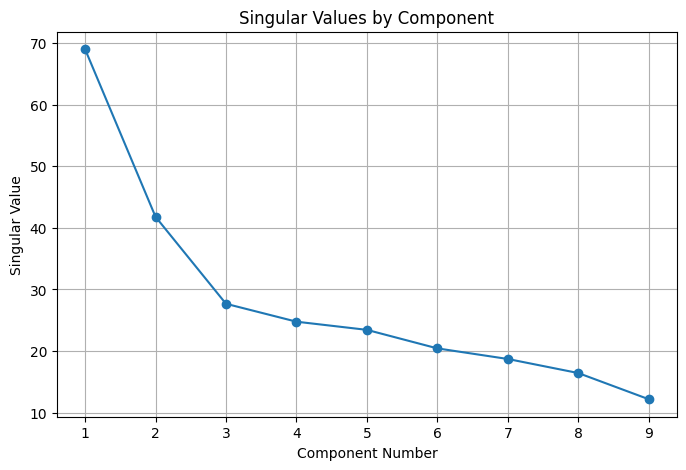

In [25]:
def plot_singular_values(svd):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(svd.singular_values_) + 1), svd.singular_values_, marker='o')
    plt.title("Singular Values by Component")
    plt.xlabel("Component Number")
    plt.ylabel("Singular Value")
    plt.grid()
    plt.show()

plot_singular_values(svd_for_analysis)

### Latent Components

                aroma    flavor  aftertaste   acidity      body   balance  \
Component 1  0.375217  0.435028    0.429825  0.397113  0.358097  0.399253   
Component 2 -0.096539 -0.031806   -0.048133 -0.110322 -0.146762 -0.037744   
Component 3 -0.081608 -0.027372   -0.022967 -0.007502  0.244565  0.057335   
Component 4  0.122565  0.041273    0.036726 -0.147828 -0.102802 -0.026764   
Component 5 -0.513753 -0.218183   -0.090872 -0.196783  0.657204  0.362022   
Component 6  0.698740 -0.143644   -0.232736 -0.492417  0.398112 -0.139835   
Component 7  0.069607 -0.023544    0.170684 -0.505636 -0.419152  0.713076   
Component 8 -0.241759  0.406211    0.573887 -0.507208  0.116959 -0.409376   
Component 9 -0.112865  0.757289   -0.624623 -0.118722 -0.008337  0.092131   

             uniformity  clean_cup  sweetness  
Component 1    0.118429   0.152212   0.051817  
Component 2    0.571217   0.563377   0.555459  
Component 3   -0.454476  -0.281340   0.802002  
Component 4   -0.659245   0.712956  -

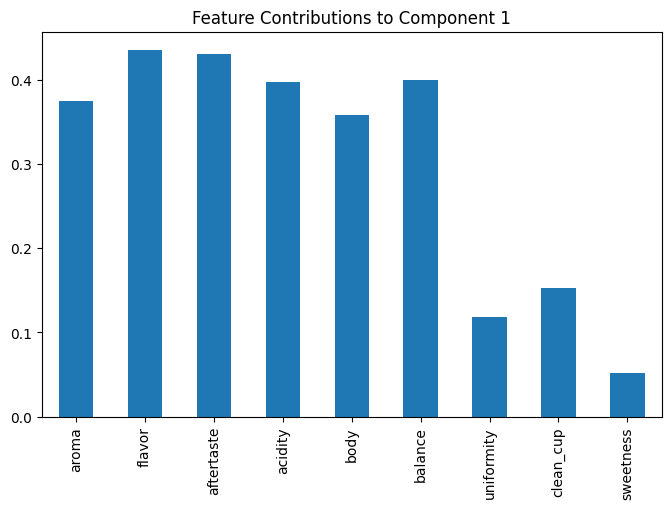

In [26]:
# Create a DataFrame of components
components_df = pd.DataFrame(Vt, columns=feature_cols, index=[f'Component {i+1}' for i in range(svd_for_analysis.n_components)])

print(components_df)

# Visualize the first component
components_df.iloc[0].plot(kind='bar', figsize=(8, 5), title='Feature Contributions to Component 1')
plt.show()

### Explained Variance Ratio

Explained Variance Ratio by Component: [0.49501614 0.1815309  0.07955767 0.06371491 0.05706889 0.04335501
 0.03635374 0.02801772 0.01538502]
Cumulative Explained Variance: [0.49501614 0.67654705 0.75610472 0.81981963 0.87688852 0.92024352
 0.95659726 0.98461498 1.        ]


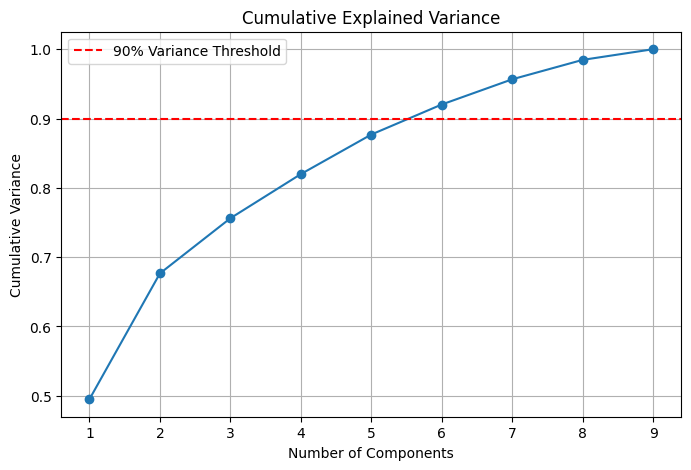

In [27]:
explained_variance = svd_for_analysis.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Explained Variance Ratio by Component:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid()
plt.show()

## NMF Results

In [28]:
W = X_train_nmf
H = best_nmf.components_

### Heatmap of H

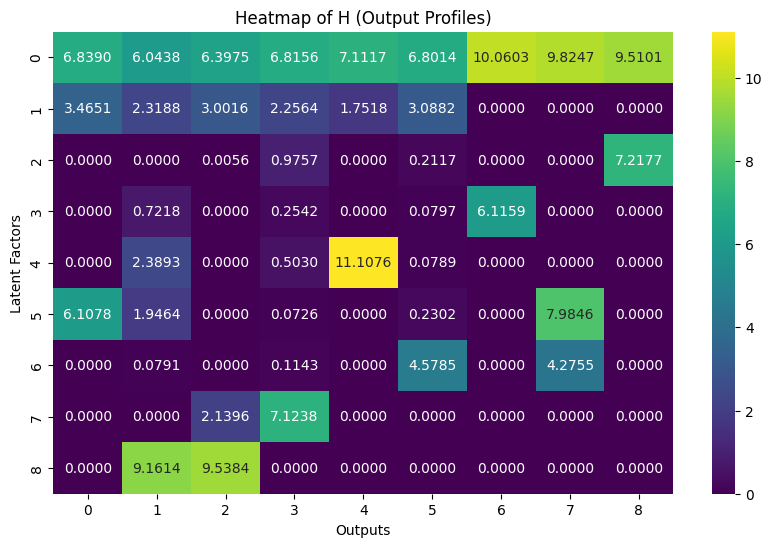

In [29]:
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(H, annot=True, cmap="viridis", fmt=".4f")
plt.title("Heatmap of H (Output Profiles)")
plt.xlabel("Outputs")
plt.ylabel("Latent Factors")
plt.show()

### Analyze User/Taste Profiles in W

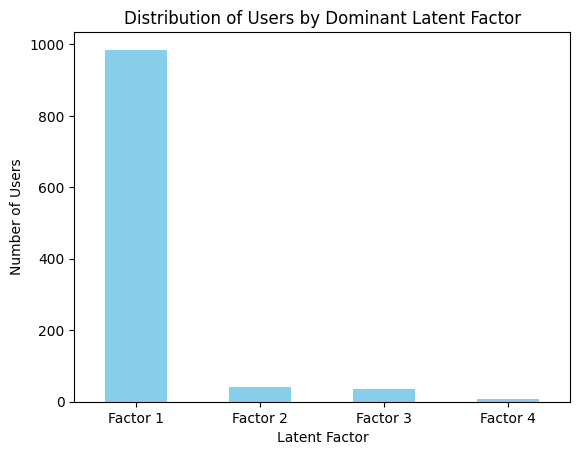

In [30]:
# Find dominant latent factor for each user
dominant_factors = np.argmax(W, axis=1)

# Count users per dominant latent factord
factor_counts = pd.Series(dominant_factors).value_counts()

# Plot distribution of users per latent factor
factor_counts.plot(kind="bar", color="skyblue")
plt.title("Distribution of Users by Dominant Latent Factor")
plt.xlabel("Latent Factor")
plt.ylabel("Number of Users")
plt.xticks(ticks=range(len(factor_counts)), labels=[f"Factor {i+1}" for i in range(len(factor_counts))], rotation=0)
plt.show()

### Error Analysis

#### SVD

In [31]:
for pred, actual in zip(svd_predictions, y_train_smote):
    print(f"Actual: {actual}")
    print(f"Recommendations: {pred}\n")

Actual: ['Taiwan' 'Typica' 'Washed / Wet']
Recommendations: (array(['Mexico', 'Mexico', 'Colombia', 'Mexico', 'Mexico'], dtype=object), array(['Typica', 'Typica', 'Caturra', 'Typica', 'Typica'], dtype=object), array(['Washed / Wet', 'Washed / Wet', 'Washed / Wet', 'Washed / Wet',
       'Washed / Wet'], dtype=object))

Actual: ['United States' 'Hawaiian Kona' 'Other']
Recommendations: (array(['Other', 'East Africa', 'Other', 'East Africa', 'East Africa'],
      dtype=object), array(['Other', 'Other', 'Other', 'Other', 'Other'], dtype=object), array(['Other', 'Other', 'Other', 'Natural / Dry', 'Other'], dtype=object))

Actual: ['Taiwan' 'Typica' 'Washed / Wet']
Recommendations: (array(['Asia Pacific', 'Brazil', 'Colombia', 'Guatemala', 'Guatemala'],
      dtype=object), array(['Other', 'Bourbon', 'Caturra', 'Caturra', 'Pacas'], dtype=object), array(['Other', 'Natural / Dry', 'Washed / Wet', 'Washed / Wet',
       'Washed / Wet'], dtype=object))

Actual: ['United States' 'Other' 'Washed 

#### NMF